In [1]:
# Python bibliotekos
import numpy as np                  # "numpy" yra biblioteka darbui su didelėmis, daugiamatėmis masyvų ir matricų kolekcijomis bei matematinėmis funkcijomis
import pandas as pd                 # "pandas" suteikia struktūras duomenims ir įrankius jų analizei, pvz., DataFrame
import matplotlib.pyplot as plt     # "matplotlib.pyplot" yra vizualizacijos biblioteka, leidžianti piešti įvairius grafikus
import warnings                     # "warnings" leidžia valdyti įspėjimus: juos ignoruoti, spausdinti, ar klaidinti
import requests                     # "requests" leidžia siųsti HTTP užklausas naudojant Python
from datetime import datetime       # "datetime" modulis suteikia funkcijas darbui su data ir laiku
from bs4 import BeautifulSoup       # "BeautifulSoup" padeda atlikti internetinių puslapių šaltinio kodo (HTML, XML) analizę ir duomenų surinkimą
import time                         # "time" modulis suteikia funkcijas, susijusias su laiku, pvz., laiko gaišimą ar laiko matavimą
import sqlite3                      # "sqlite3" leidžia dirbti su SQLite duomenų bazėmis, atliekant duomenų saugojimo, atnaujinimo ir gavimo operacijas
from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppressing warnings
warnings.filterwarnings('ignore')   # Nustato, kad visi įspėjimai būtų ignoruojami

# Set up Selenium webdriver options
from selenium import webdriver                          # "selenium.webdriver" leidžia automatizuoti veiksmus interneto naršyklėje
from selenium.webdriver.chrome.options import Options   # "Options" leidžia nustatyti konfigūracijas Chrome naršyklės draiveriui

# Papildomai importuojame: 
from sklearn.linear_model import LinearRegression  # Tiesinės regresijos modelis
from sklearn.model_selection import train_test_split  # Duomenų padalijimas į treniravimo ir testavimo rinkinius
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor



In [2]:
# Nuoroda Lietuvos elektros suvartojimui 
# https://data.nordpoolgroup.com/power-system/consumption?deliveryDate=2025-01-09&deliveryAreas=AT&aggregation=DeliveryPeriod

In [3]:
# Surenkame elektros suvartojima is 4 lenteliu 
file_path = 'C:\\Users\\Pauliussl\\Paskaita74\\b2c_ngv_vartojimas.xlsx'
data = pd.read_excel(file_path)
data['dateTime'] = pd.to_datetime(data['dateTime'], errors='coerce')
data['Viso'] = data.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data = data[['dateTime', 'Viso']]

file_path2 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2c_gv_vartojimas.xlsx'
data2 = pd.read_excel(file_path2)
data2['dateTime'] = pd.to_datetime(data2['dateTime'], errors='coerce')
data2['Viso1'] = data2.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data2 = data2[['dateTime', 'Viso1']]

file_path3 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2b_ngv_vartojimas.xlsx'
data3 = pd.read_excel(file_path3)
data3['dateTime'] = pd.to_datetime(data3['dateTime'], errors='coerce')
data3['Viso2'] = data3.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data3 = data3[['dateTime', 'Viso2']]

file_path4 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2b_gv_vartojimas.xlsx'
data4 = pd.read_excel(file_path4)
data4['dateTime'] = pd.to_datetime(data4['dateTime'], errors='coerce')
data4['Viso3'] = data4.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data4 = data4[['dateTime', 'Viso3']]

bendra_lentele = pd.merge(left = data2, right= data, left_on= 'dateTime', right_on= 'dateTime', how='inner')
bendra_lentele = pd.merge(left = bendra_lentele, right= data3, left_on= 'dateTime', right_on= 'dateTime', how='inner')
bendra_lentele = pd.merge(left = bendra_lentele, right= data4, left_on= 'dateTime', right_on= 'dateTime', how='inner')


In [4]:
# Sutvarkome elektros suvartojima ir prijungiame oru lentele. 

bendra_lentele['dateTime'] = pd.to_datetime(bendra_lentele['dateTime'], errors='coerce')  # Konvertuojame 'dateTime' stulpelį į datetime formatą, ignoruojant klaidas
bendra_lentele['viso'] = bendra_lentele.iloc[:, 1:].sum(axis=1)                          # Sukuriame naują stulpelį 'viso', kuris yra visų kitų stulpelių suma
bendra_lentele = bendra_lentele.drop(columns=['Viso1', 'Viso2', 'Viso', 'Viso3'], errors='ignore')  # Pašaliname nurodytus stulpelius, ignoruojant klaidas, jei jų nėra
bendra_lentele.head()                                                                    # Peržiūrime pirmas kelias lentelės eilutes

testavimo_lentele = bendra_lentele[bendra_lentele['dateTime'] < '2023-10-30']            # Filtruojame eiles, kuriose 'dateTime' yra mažesnis už 2023-10-30
testavimo_lentele.head()                                                                 # Peržiūrime pirmas kelias testavimo lentelės eilutes

file_path_orai = 'C:\\Users\\Pauliussl\\Paskaita74\\oru_prognoze.csv'                    # Nurodome kelią iki CSV failo su orų duomenimis
data5 = pd.read_csv(file_path_orai)                                                     # Įkeliame CSV failą į duomenų rėmelį 'data5'
data5 = data5.rename(columns={'obs_time_utc':'dateTime'})                               # Pervadiname stulpelį 'obs_time_utc' į 'dateTime'
data5['dateTime'] = pd.to_datetime(data5['dateTime'], errors='coerce')                  # Konvertuojame 'dateTime' stulpelį į datetime formatą, ignoruojant klaidas
data5.head()                                                                            # Peržiūrime pirmas kelias lentelės eilutes

elektra_orai = pd.merge(left=testavimo_lentele, right=data5, left_on='dateTime', right_on='dateTime', how='inner')  # Atliekame sujungimą pagal 'dateTime'
elektra_orai = elektra_orai.drop(columns=['condition_code'], errors='ignore')           # Pašaliname stulpelį 'condition_code', jei jis egzistuoja
elektra_orai.head()                                                                     # Peržiūrime pirmas kelias sujungtos lentelės eilutes

# Paruošiame galutinę lentelę modelio apmokymui
elektra_orai = elektra_orai.drop(columns=['wind_direction', 'precipitation'])           # Pašaliname stulpelius 'wind_direction' ir 'precipitation'
elektra_orai['savaites_diena'] = elektra_orai['dateTime'].dt.weekday                    # Sukuriame naują stulpelį 'savaites_diena', kuris nurodo savaitės dieną (0 = pirmadienis)
elektra_orai['menesis'] = elektra_orai['dateTime'].dt.month                             # Sukuriame naują stulpelį 'menesis', kuris nurodo mėnesį (1 = sausis, 12 = gruodis)
elektra_orai['valanda'] = elektra_orai['dateTime'].dt.hour                              # Sukuriame naują stulpelį 'valanda', kuris nurodo valandą (0–23)
elektra_orai = elektra_orai.drop(columns=['dateTime'])                                  # Pašaliname stulpelį 'dateTime', nes jis jau nebereikalingas
elektra_orai = elektra_orai.dropna(subset=['cloud_cover'])                              # Pašaliname eiles, kuriose 'cloud_cover' turi NaN reikšmes
elektra_orai                                                                               # Peržiūrime galutinę lentelę


,viso,air_temperature,feels_like_temperature,wind_speed,wind_gust,cloud_cover,sea_level_pressure,relative_humidity,savaites_diena,menesis,valanda
0,7528.222124,14.8,14.8,2.1,3.2,25.0,1007.7,82,1,8,0
1,7300.200090,13.8,13.8,1.5,2.6,25.0,1008.0,87,1,8,1
2,7114.172580,13.6,13.6,1.7,2.8,50.0,1007.6,86,1,8,2
3,7025.618630,13.5,13.5,1.3,2.8,100.0,1007.5,87,1,8,3
4,7298.095296,15.0,15.0,1.6,2.9,0.0,1007.0,82,1,8,4
...,...,...,...,...,...,...,...,...,...,...,...
2155,10682.174280,2.7,-1.3,4.6,9.5,100.0,1007.5,98,6,10,19
2156,10204.631775,4.2,0.0,5.6,10.7,100.0,1006.6,98,6,10,20
2157,9593.699044,5.1,5.1,5.1,10.1,100.0,1005.9,99,6,10,21
2158,9045.732662,6.0,6.0,5.0,10.4,100.0,1005.6,98,6,10,22


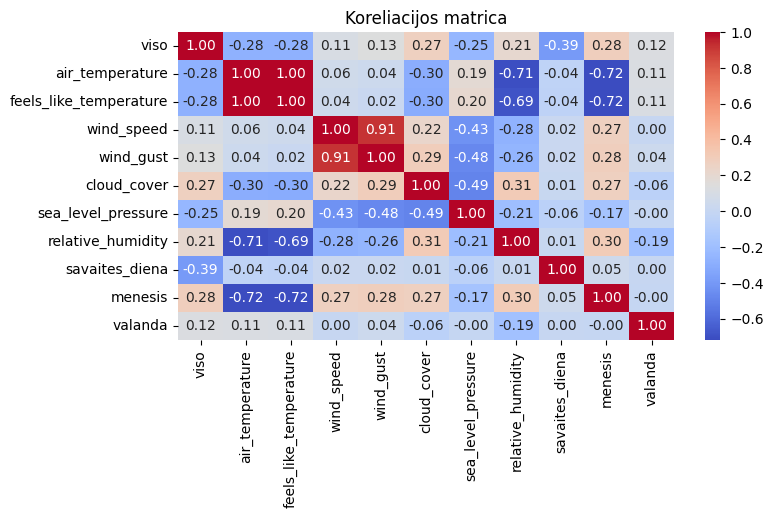

In [5]:
# Nusibrežiame correlation heatmap
correlation_matrix = elektra_orai.corr()                                         # Sukuriame koreliacijos matricą tarp visų stulpelių
correlation_with_viso = correlation_matrix['viso'].sort_values(ascending=False)  # Surikiuojame koreliaciją su 'viso' mažėjančia tvarka

plt.figure(figsize=(8, 4))                                                       # Nustatome grafiko dydį
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")          # Sukuriame koreliacijos šilumos žemėlapį
plt.title("Koreliacijos matrica")                                                # Nustatome grafiko pavadinimą
plt.savefig("graph1.png")
plt.show()                                                                       # Parodome grafiką


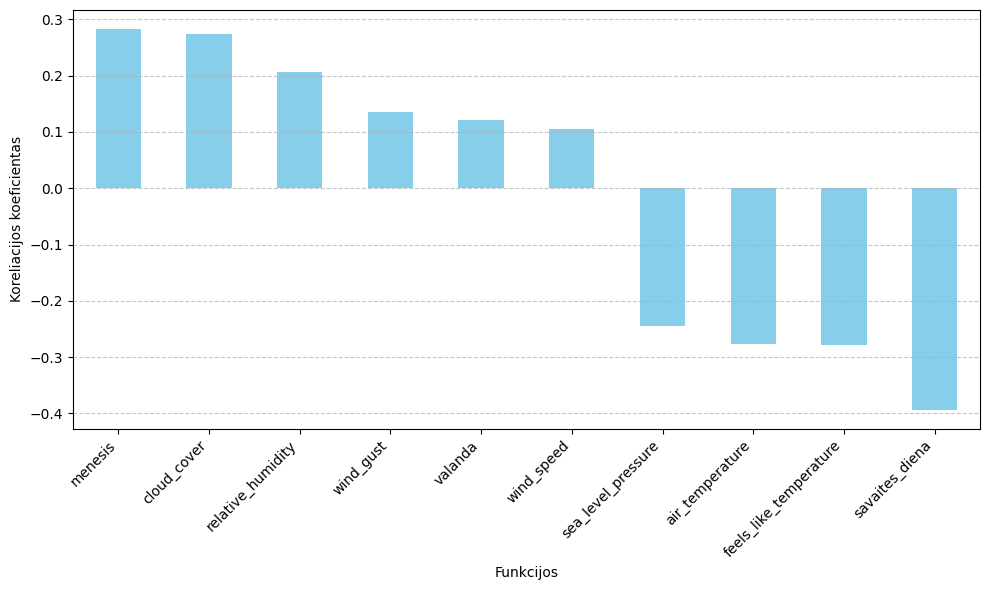

In [6]:
# Nusibreziame correlatio bar diagrama
correlation_matrix = elektra_orai.corr()                      # Sukuriame koreliacijos matricą tarp visų stulpelių
correlation_with_viso = correlation_matrix['viso'].sort_values(ascending=False)  # Surikiuojame koreliaciją su 'viso' mažėjančia tvarka

plt.figure(figsize=(10, 6))                                   # Nustatome grafiko dydį
correlation_with_viso.drop('viso').plot(kind='bar', color='skyblue')  # Sukuriame barų diagramą, išskyrus 'viso' stulpelį
plt.ylabel("Koreliacijos koeficientas")                       # Pridedame Y ašies pavadinimą
plt.xlabel("Funkcijos")                                       # Pridedame X ašies pavadinimą
plt.xticks(rotation=45, ha='right')                           # Pasukame X ašies žymes, kad jos būtų geriau matomos
plt.grid(axis='y', linestyle='--', alpha=0.7)                 # Pridedame tinklelius Y ašiai su lengvu stilizavimu
plt.tight_layout()                                            # Automatiškai sutvarkome išdėstymą, kad niekas neperdengtų
plt.savefig("graph2.png")
plt.show()                                                    # Parodome grafiką

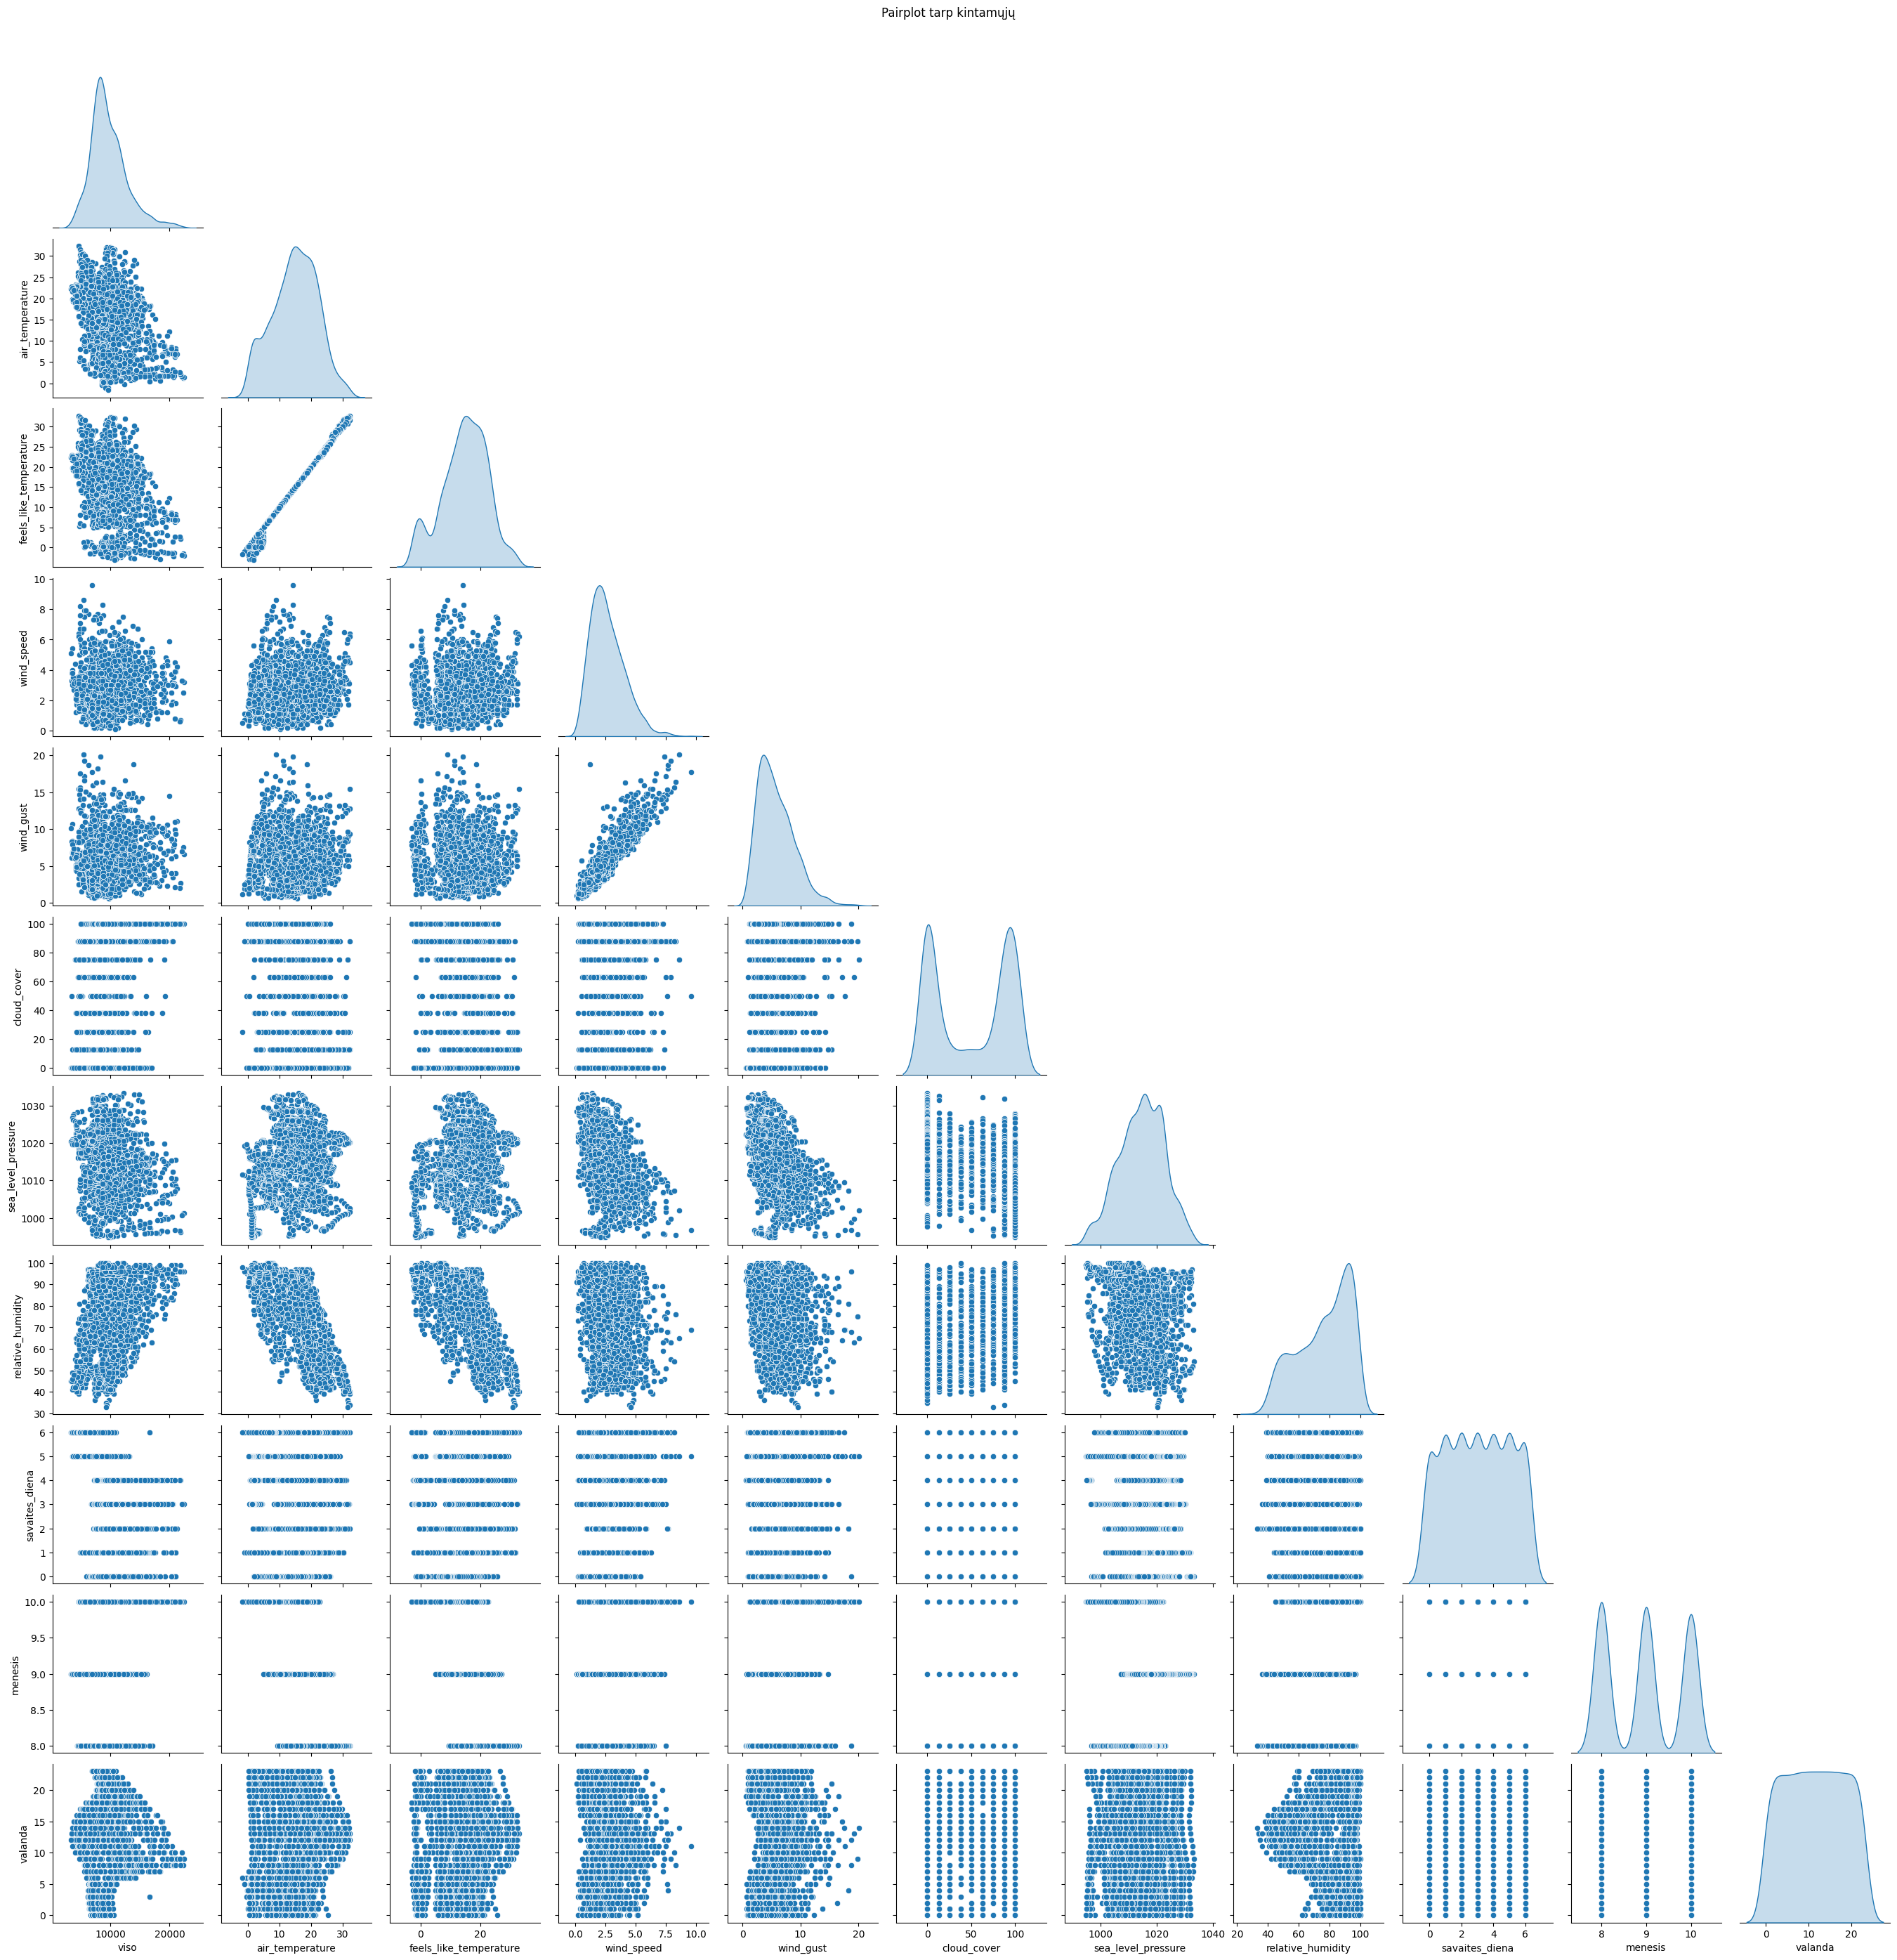

In [7]:
# Nusibraizome Pairplot 
sns.pairplot(elektra_orai, diag_kind="kde", kind="scatter", corner=True)         # Naudojame KDE diagnostikai ir scatter taškams
plt.suptitle("Pairplot tarp kintamųjų", y=1.02)                                  # Pridedame pavadinimą viršuje
plt.show()                                                                       # Parodome grafiką


In [8]:
# Pasidarome lentele Spalio 30 dienai (oru)
file_path_orai = 'C:\\Users\\Pauliussl\\Paskaita74\\spalio_30_oras.csv'                    # Nurodome kelią iki CSV failo su orų duomenimis
data6 = pd.read_csv(file_path_orai)                                                     # Įkeliame CSV failą į duomenų rėmelį 'data5'
data6 = data6.rename(columns={'obs_time_utc':'dateTime'})                               # Pervadiname stulpelį 'obs_time_utc' į 'dateTime'
data6['dateTime'] = pd.to_datetime(data6['dateTime'], errors='coerce')                  # Konvertuojame 'dateTime' stulpelį į datetime formatą, ignoruojant klaidas
data6 = data6.drop(columns=['wind_direction', 'precipitation', 'condition_code'])           # Pašaliname stulpelius 'wind_direction' ir 'precipitation'
data6['savaites_diena'] = data6['dateTime'].dt.weekday                    # Sukuriame naują stulpelį 'savaites_diena', kuris nurodo savaitės dieną (0 = pirmadienis)
data6['menesis'] = data6['dateTime'].dt.month                             # Sukuriame naują stulpelį 'menesis', kuris nurodo mėnesį (1 = sausis, 12 = gruodis)
data6['valanda'] = data6['dateTime'].dt.hour                              # Sukuriame naują stulpelį 'valanda', kuris nurodo valandą (0–23)
data6 = data6.drop(columns=['dateTime'])                                  # Pašaliname stulpelį 'dateTime', nes jis jau nebereikalingas
data6 = data6.dropna(subset=['cloud_cover'])                              # Pašaliname eiles, kuriose 'cloud_cover' turi NaN reikšmes
                                                                          # Peržiūrime galutinę lentelę
data6.head()  

,air_temperature,feels_like_temperature,wind_speed,wind_gust,cloud_cover,sea_level_pressure,relative_humidity,savaites_diena,menesis,valanda
0,7.0,7.0,3.6,6.0,88,1004.6,99,0,10,0
1,7.4,7.4,3.3,5.8,100,1004.3,98,0,10,1
2,7.9,7.9,3.4,5.8,100,1003.5,99,0,10,2
3,8.4,8.4,3.2,6.3,88,1003.0,99,0,10,3
4,8.7,8.7,3.9,6.8,88,1002.7,99,0,10,4


mean_absolute_error: 665.7223843291862 mean_squared_error: 1041674.7807304055 r2: 0.8862213509676026


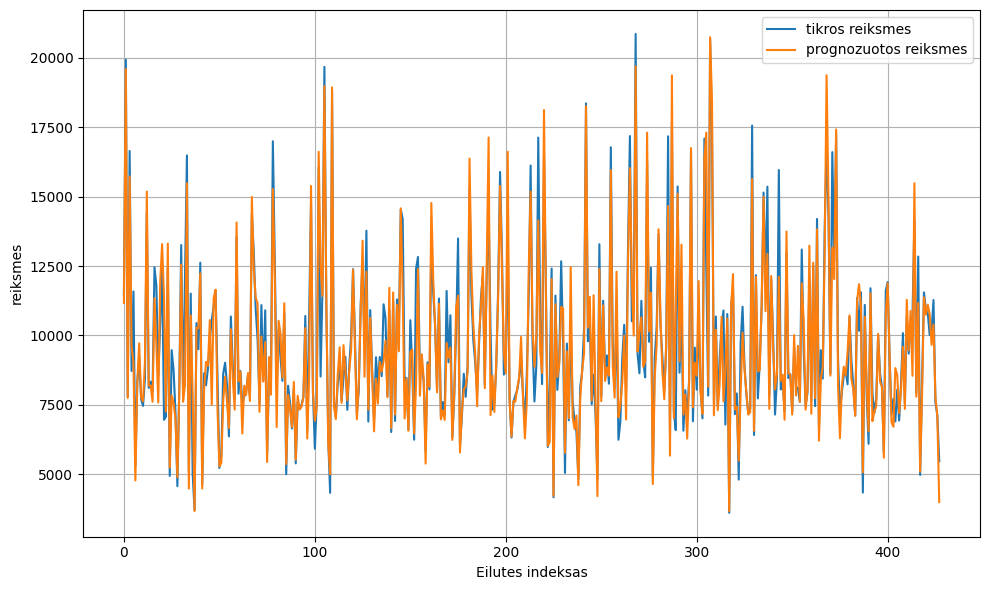

In [9]:
# Modelis: DecisionTreeRegressor 

X = elektra_orai.drop(columns=['viso'])                                         # Pašaliname tikslinį kintamąjį 'viso', paliekant tik nepriklausomus kintamuosius
y = elektra_orai['viso']                                                        # Tikslinis kintamasis yra 'viso'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Padalijame duomenis į mokymo (80%) ir testavimo (20%) rinkinius

model = DecisionTreeRegressor(random_state=42)                                  # Sukuriame sprendimų medžio regresijos modelį su fiksuota random_state reikšme
model.fit(X_train, y_train)                                                     # Apmokome modelį naudojant mokymo duomenis

y_pred = model.predict(X_test)                                                 # Atliekame prognozę testavimo duomenims

# Tikslumo metrikos
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('mean_absolute_error:', mae,
      'mean_squared_error:', mse,
      'r2:', r2)

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label = 'tikros reiksmes')
plt.plot(y_pred, label='prognozuotos reiksmes')
plt.legend()
plt.xlabel('Eilutes indeksas')
plt.ylabel('reiksmes')
plt.grid(True)
plt.tight_layout()
plt.savefig("graph3.png")
plt.show()

### Modelio uzdejimas ant 24h
from sklearn.tree import DecisionTreeRegressor                             # Importuojame reikiamas bibliotekas
X = data6[['air_temperature', 'feels_like_temperature', 'wind_speed',      # Paruošiame prognozavimo duomenis
           'wind_gust', 'cloud_cover', 'sea_level_pressure', 
           'relative_humidity', 'savaites_diena', 'menesis', 'valanda']]
data6['DecisionTreeRegressor'] = model.predict(X)                              # Atlikite prognozes naudojant jau apmokytą modelį


In [10]:
data6.head()

,air_temperature,feels_like_temperature,wind_speed,wind_gust,cloud_cover,sea_level_pressure,relative_humidity,savaites_diena,menesis,valanda,DecisionTreeRegressor
0,7.0,7.0,3.6,6.0,88,1004.6,99,0,10,0,7955.728867
1,7.4,7.4,3.3,5.8,100,1004.3,98,0,10,1,6962.847926
2,7.9,7.9,3.4,5.8,100,1003.5,99,0,10,2,8081.781676
3,8.4,8.4,3.2,6.3,88,1003.0,99,0,10,3,8584.894218
4,8.7,8.7,3.9,6.8,88,1002.7,99,0,10,4,8584.894218


In [11]:
# 8. Kintamųjų, paduotų į modelį, ištraukimas
model_features = X.columns.tolist()
print('Kintamieji, paduoti į modelį:', model_features)

Kintamieji, paduoti į modelį: ['air_temperature', 'feels_like_temperature', 'wind_speed', 'wind_gust', 'cloud_cover', 'sea_level_pressure', 'relative_humidity', 'savaites_diena', 'menesis', 'valanda']


mean_absolute_error: 1805.6187895220594 mean_squared_error: 5819286.261970584 r2: 0.3643788431207463


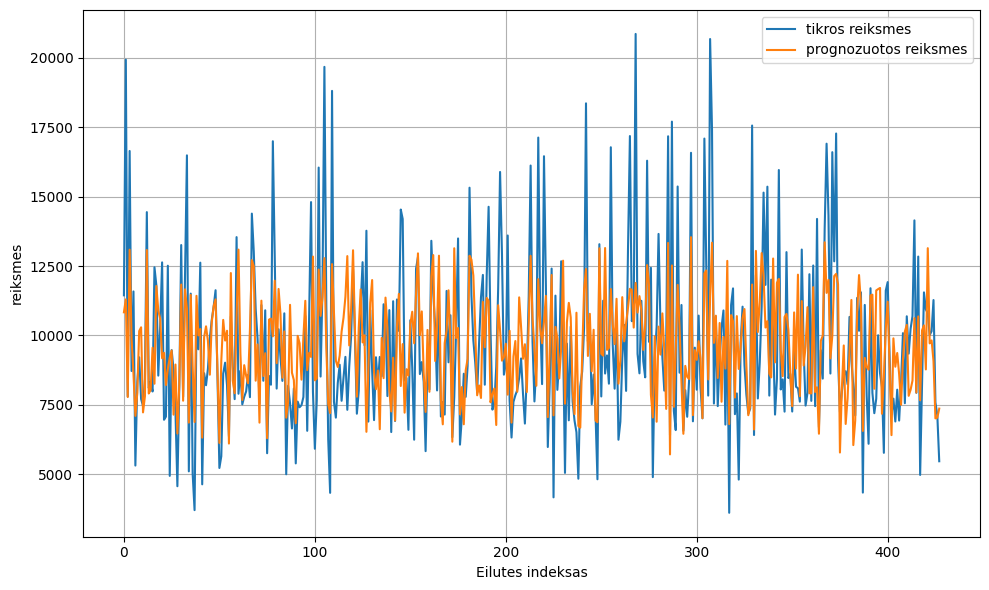

In [12]:
# Modelis: LinearRegression

from sklearn.linear_model import LinearRegression

X = elektra_orai.drop(columns=['viso'])                                         # Pašaliname tikslinį kintamąjį 'viso', paliekant tik nepriklausomus kintamuosius
y = elektra_orai['viso']                                                        # Tikslinis kintamasis yra 'viso'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Padalijame duomenis į mokymo (80%) ir testavimo (20%) rinkinius

model = LinearRegression()                                                      # Sukuriame tiesinės regresijos modelį
model.fit(X_train, y_train)                                                     # Apmokome modelį naudojant mokymo duomenis

y_pred = model.predict(X_test)                                                  # Atliekame prognozę testavimo duomenims

# Tikslumo metrikos
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('mean_absolute_error:', mae,
      'mean_squared_error:', mse,
      'r2:', r2)

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label = 'tikros reiksmes')
plt.plot(y_pred, label='prognozuotos reiksmes')
plt.legend()
plt.xlabel('Eilutes indeksas')
plt.ylabel('reiksmes')
plt.grid(True)
plt.tight_layout()
plt.savefig("graph4.png")
plt.show()

### Modelio uzdejimas ant 24h
from sklearn.tree import DecisionTreeRegressor                             # Importuojame reikiamas bibliotekas
X = data6[['air_temperature', 'feels_like_temperature', 'wind_speed',      # Paruošiame prognozavimo duomenis
           'wind_gust', 'cloud_cover', 'sea_level_pressure', 
           'relative_humidity', 'savaites_diena', 'menesis', 'valanda']]
data6['LinearRegression'] = model.predict(X)                              # Atlikite prognozes naudojant jau apmokytą modelį

In [13]:
data6.head()

,air_temperature,feels_like_temperature,wind_speed,wind_gust,cloud_cover,sea_level_pressure,relative_humidity,savaites_diena,menesis,valanda,DecisionTreeRegressor,LinearRegression
0,7.0,7.0,3.6,6.0,88,1004.6,99,0,10,0,7955.728867,12903.170162
1,7.4,7.4,3.3,5.8,100,1004.3,98,0,10,1,6962.847926,13100.083037
2,7.9,7.9,3.4,5.8,100,1003.5,99,0,10,2,8081.781676,13199.864674
3,8.4,8.4,3.2,6.3,88,1003.0,99,0,10,3,8584.894218,13178.834211
4,8.7,8.7,3.9,6.8,88,1002.7,99,0,10,4,8584.894218,13209.960946


mean_absolute_error: 474.17321859086786 mean_squared_error: 541746.3660568128 r2: 0.9408268580670308


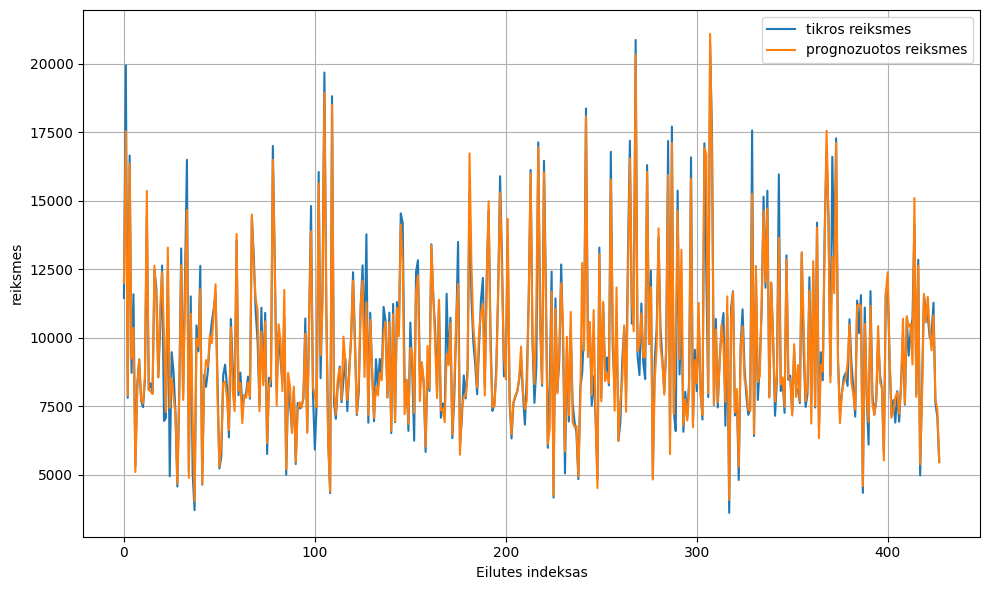

In [14]:
# Modelis: RandomForestRegressor 

from sklearn.linear_model import LinearRegression

X = elektra_orai.drop(columns=['viso'])                                         # Pašaliname tikslinį kintamąjį 'viso', paliekant tik nepriklausomus kintamuosius
y = elektra_orai['viso']                                                        # Tikslinis kintamasis yra 'viso'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Padalijame duomenis į mokymo (80%) ir testavimo (20%) rinkinius

model = RandomForestRegressor(n_estimators=100, random_state=42)                                                     # Sukuriame tiesinės regresijos modelį
model.fit(X_train, y_train)                                                     # Apmokome modelį naudojant mokymo duomenis
y_pred = model.predict(X_test)  

# Tikslumo metrikos
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('mean_absolute_error:', mae,
      'mean_squared_error:', mse,
      'r2:', r2)

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label = 'tikros reiksmes')
plt.plot(y_pred, label='prognozuotos reiksmes')
plt.legend()
plt.xlabel('Eilutes indeksas')
plt.ylabel('reiksmes')
plt.grid(True)
plt.tight_layout()
plt.show()

### Modelio uzdejimas ant 24h
from sklearn.tree import DecisionTreeRegressor                             # Importuojame reikiamas bibliotekas
X = data6[['air_temperature', 'feels_like_temperature', 'wind_speed',      # Paruošiame prognozavimo duomenis
           'wind_gust', 'cloud_cover', 'sea_level_pressure', 
           'relative_humidity', 'savaites_diena', 'menesis', 'valanda']]
data6['RandomForrest'] = model.predict(X)                              # Atlikite prognozes naudojant jau apmokytą modelį


In [15]:
data6.head()

,air_temperature,feels_like_temperature,wind_speed,wind_gust,cloud_cover,sea_level_pressure,relative_humidity,savaites_diena,menesis,valanda,DecisionTreeRegressor,LinearRegression,RandomForrest
0,7.0,7.0,3.6,6.0,88,1004.6,99,0,10,0,7955.728867,12903.170162,8358.711433
1,7.4,7.4,3.3,5.8,100,1004.3,98,0,10,1,6962.847926,13100.083037,8194.479227
2,7.9,7.9,3.4,5.8,100,1003.5,99,0,10,2,8081.781676,13199.864674,7898.803482
3,8.4,8.4,3.2,6.3,88,1003.0,99,0,10,3,8584.894218,13178.834211,7826.561386
4,8.7,8.7,3.9,6.8,88,1002.7,99,0,10,4,8584.894218,13209.960946,7884.049950


mean_absolute_error: 1918.189145649481 mean_squared_error: 7347741.8513807645 r2: 0.19743075597672688


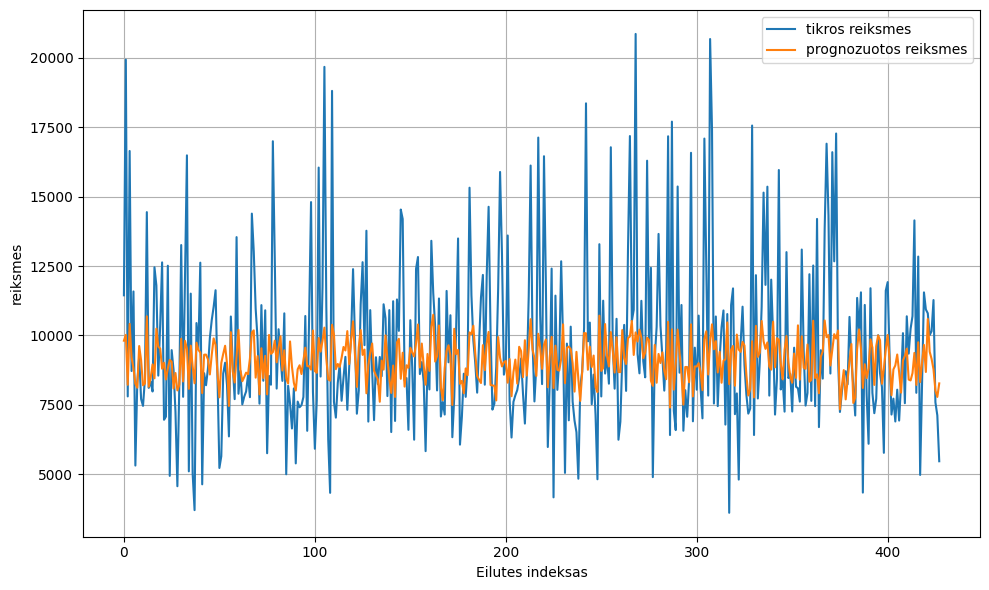

In [16]:
# Modelis: Support Vector machine 
# skirtingi tipai: linear,poly, rbf

X = elektra_orai.drop(columns=['viso'])                                         # Pašaliname tikslinį kintamąjį 'viso'
y = elektra_orai['viso']                                                        # Tikslinis kintamasis yra 'viso'

scaler = StandardScaler()                                                       # Sukuriame normalizacijos (standartizacijos) objektą
X = scaler.fit_transform(X)                                                     # Normalizuojame nepriklausomus kintamuosius (vidurkis = 0, std = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Padalijame duomenis į mokymo (80%) ir testavimo (20%) rinkinius

model = SVR(kernel='linear', C=1.0, epsilon=0.1)                                   # Sukuriame Support Vector Regressor modelį su RBF branduoliu, C = 1.0 ir epsilon = 0.1
model.fit(X_train, y_train)                                                     # Apmokome modelį naudojant mokymo duomenis
y_pred = model.predict(X_test)                                                  # Atliekame prognozę testavimo duomenims

# Tikslumo metrikos
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('mean_absolute_error:', mae,
      'mean_squared_error:', mse,
      'r2:', r2)

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label = 'tikros reiksmes')
plt.plot(y_pred, label='prognozuotos reiksmes')
plt.legend()
plt.xlabel('Eilutes indeksas')
plt.ylabel('reiksmes')
plt.grid(True)
plt.tight_layout()
plt.show()

### Modelio uzdejimas ant 24h
from sklearn.tree import DecisionTreeRegressor                             # Importuojame reikiamas bibliotekas
X = data6[['air_temperature', 'feels_like_temperature', 'wind_speed',      # Paruošiame prognozavimo duomenis
           'wind_gust', 'cloud_cover', 'sea_level_pressure', 
           'relative_humidity', 'savaites_diena', 'menesis', 'valanda']]
data6['SVM'] = model.predict(X)                              # Atlikite prognozes naudojant jau apmokytą modelį

In [17]:
data6

,air_temperature,feels_like_temperature,wind_speed,wind_gust,cloud_cover,sea_level_pressure,relative_humidity,savaites_diena,menesis,valanda,DecisionTreeRegressor,LinearRegression,RandomForrest,SVM
0,7.0,7.0,3.6,6.0,88,1004.6,99,0,10,0,7955.728867,12903.170162,8358.711433,-138184.444975
1,7.4,7.4,3.3,5.8,100,1004.3,98,0,10,1,6962.847926,13100.083037,8194.479227,-135792.858628
2,7.9,7.9,3.4,5.8,100,1003.5,99,0,10,2,8081.781676,13199.864674,7898.803482,-135476.773407
3,8.4,8.4,3.2,6.3,88,1003.0,99,0,10,3,8584.894218,13178.834211,7826.561386,-137338.062701
4,8.7,8.7,3.9,6.8,88,1002.7,99,0,10,4,8584.894218,13209.960946,7884.049950,-136973.023903
5,9.1,9.1,4.8,7.6,88,1002.5,97,0,10,5,8584.894218,13204.807553,8061.192104,-136586.694351
6,9.2,9.2,3.4,7.5,88,1002.8,96,0,10,6,12162.554293,13329.106140,12660.783331,-136458.299679
7,10.0,10.0,3.6,6.6,88,1002.9,96,0,10,7,16619.615433,13343.539363,16271.892805,-136411.932213
8,11.0,11.0,4.3,7.6,88,1003.4,91,0,10,8,16619.615433,13264.735336,17240.694348,-136223.790324
9,11.9,11.9,4.3,10.7,88,1003.7,86,0,10,9,19597.461799,13256.552977,17048.388148,-135839.659420


In [18]:
# Faktinis sunaudojimas Spalio 30 dienai
file_path = 'C:\\Users\\Pauliussl\\Paskaita74\\b2c_ngv_vartojimas.xlsx'
data = pd.read_excel(file_path)
data['dateTime'] = pd.to_datetime(data['dateTime'], errors='coerce')
data['Viso'] = data.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data = data[['dateTime', 'Viso']]
data = data[data['dateTime'].dt.date == pd.Timestamp('2023-10-30').date()]  # Filtruojame tik 2023-10-30 duomenis

file_path2 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2c_gv_vartojimas.xlsx'
data2 = pd.read_excel(file_path2)
data2['dateTime'] = pd.to_datetime(data2['dateTime'], errors='coerce')
data2['Viso1'] = data2.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data2 = data2[['dateTime', 'Viso1']]
data2 = data2[data2['dateTime'].dt.date == pd.Timestamp('2023-10-30').date()]  # Filtruojame tik 2023-10-30 duomenis

file_path3 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2b_ngv_vartojimas.xlsx'
data3 = pd.read_excel(file_path3)
data3['dateTime'] = pd.to_datetime(data3['dateTime'], errors='coerce')
data3['Viso2'] = data3.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data3 = data3[['dateTime', 'Viso2']]
data3 = data3[data3['dateTime'].dt.date == pd.Timestamp('2023-10-30').date()]  # Filtruojame tik 2023-10-30 duomenis

file_path4 = 'C:\\Users\\Pauliussl\\Paskaita74\\b2b_gv_vartojimas.xlsx'
data4 = pd.read_excel(file_path4)
data4['dateTime'] = pd.to_datetime(data4['dateTime'], errors='coerce')
data4['Viso3'] = data4.iloc[:, 1:].select_dtypes(include='number').sum(axis=1)
data4 = data4[['dateTime', 'Viso3']]
data4 = data4[data4['dateTime'].dt.date == pd.Timestamp('2023-10-30').date()]  # Filtruojame tik 2023-10-30 duomenis

# Sukuriame bendrą lentelę, sujungdami visus filtruotus duomenis
bendra_lentele1 = pd.merge(left=data2, right=data, on='dateTime', how='inner')
bendra_lentele1 = pd.merge(left=bendra_lentele1, right=data3, on='dateTime', how='inner')
bendra_lentele1 = pd.merge(left=bendra_lentele1, right=data4, on='dateTime', how='inner')

# Parodome rezultatą
print(bendra_lentele1)

# bendra_lentele1 = bendra_lentele1.drop(columns=['Viso','Viso2','Viso3'])
bendra_lentele1['valanda'] = bendra_lentele1['dateTime'].dt.hour
bendra_lentele1 = bendra_lentele1.drop(columns='dateTime')
bendra_lentele1.head()


              dateTime        Viso1        Viso       Viso2         Viso3
0  2023-10-30 00:00:00   745.340335  173.130666  428.724936   6894.730016
1  2023-10-30 01:00:00   683.211501  149.582333  412.581332   6871.828988
2  2023-10-30 02:00:00   637.173832  145.826333  402.581666   6868.991428
3  2023-10-30 03:00:00   627.920467  134.547333  394.806999   6758.376506
4  2023-10-30 04:00:00   626.576100  138.692333  437.968999   7032.918868
5  2023-10-30 05:00:00   691.266433  166.767333  489.837000   7939.782129
6  2023-10-30 06:00:00   808.859468  211.151334  585.040665  10662.621605
7  2023-10-30 07:00:00   876.396266  236.360666  660.999999  13644.566871
8  2023-10-30 08:00:00   720.391066  258.001000  825.074667  15574.605416
9  2023-10-30 09:00:00   522.039667  267.141667  955.184667  14059.200347
10 2023-10-30 10:00:00   429.541400  272.438334  990.333001  13226.936757
11 2023-10-30 11:00:00   366.991499  269.560666  947.861335  12213.307323
12 2023-10-30 12:00:00   406.428166  2

,Viso1,Viso,Viso2,Viso3,valanda
0,745.340335,173.130666,428.724936,6894.730016,0
1,683.211501,149.582333,412.581332,6871.828988,1
2,637.173832,145.826333,402.581666,6868.991428,2
3,627.920467,134.547333,394.806999,6758.376506,3
4,626.576100,138.692333,437.968999,7032.918868,4


In [19]:
bendra_lentele1['viso'] = bendra_lentele1.iloc[:, 0:4].sum(axis=1)
bendra_lentele1.head()

,Viso1,Viso,Viso2,Viso3,valanda,viso
0,745.340335,173.130666,428.724936,6894.730016,0,8241.925953
1,683.211501,149.582333,412.581332,6871.828988,1,8117.204154
2,637.173832,145.826333,402.581666,6868.991428,2,8054.573259
3,627.920467,134.547333,394.806999,6758.376506,3,7915.651305
4,626.576100,138.692333,437.968999,7032.918868,4,8236.156300


In [20]:
bendra_lentele10 = bendra_lentele1[['valanda', 'viso']]
bendra_lentele10


,valanda,viso
0,0,8241.925953
1,1,8117.204154
2,2,8054.573259
3,3,7915.651305
4,4,8236.156300
5,5,9287.652895
6,6,12267.673072
7,7,15418.323802
8,8,17378.072149
9,9,15803.566348


In [21]:
bendra_lentele3 = pd.merge(left = data6, right= bendra_lentele1, left_on= 'valanda', right_on= 'valanda', how='inner')
bendra_lentele3.rename(columns={'viso':'faktas'}, inplace = True)
bendra_lentele3
palyginimo_lentele = bendra_lentele3[['valanda', 'DecisionTreeRegressor','LinearRegression','RandomForrest','SVM','faktas']]
palyginimo_lentele = palyginimo_lentele.drop(columns='SVM')
palyginimo_lentele

,valanda,DecisionTreeRegressor,LinearRegression,RandomForrest,faktas
0,0,7955.728867,12903.170162,8358.711433,8241.925953
1,1,6962.847926,13100.083037,8194.479227,8117.204154
2,2,8081.781676,13199.864674,7898.803482,8054.573259
3,3,8584.894218,13178.834211,7826.561386,7915.651305
4,4,8584.894218,13209.960946,7884.049950,8236.156300
5,5,8584.894218,13204.807553,8061.192104,9287.652895
6,6,12162.554293,13329.106140,12660.783331,12267.673072
7,7,16619.615433,13343.539363,16271.892805,15418.323802
8,8,16619.615433,13264.735336,17240.694348,17378.072149
9,9,19597.461799,13256.552977,17048.388148,15803.566348


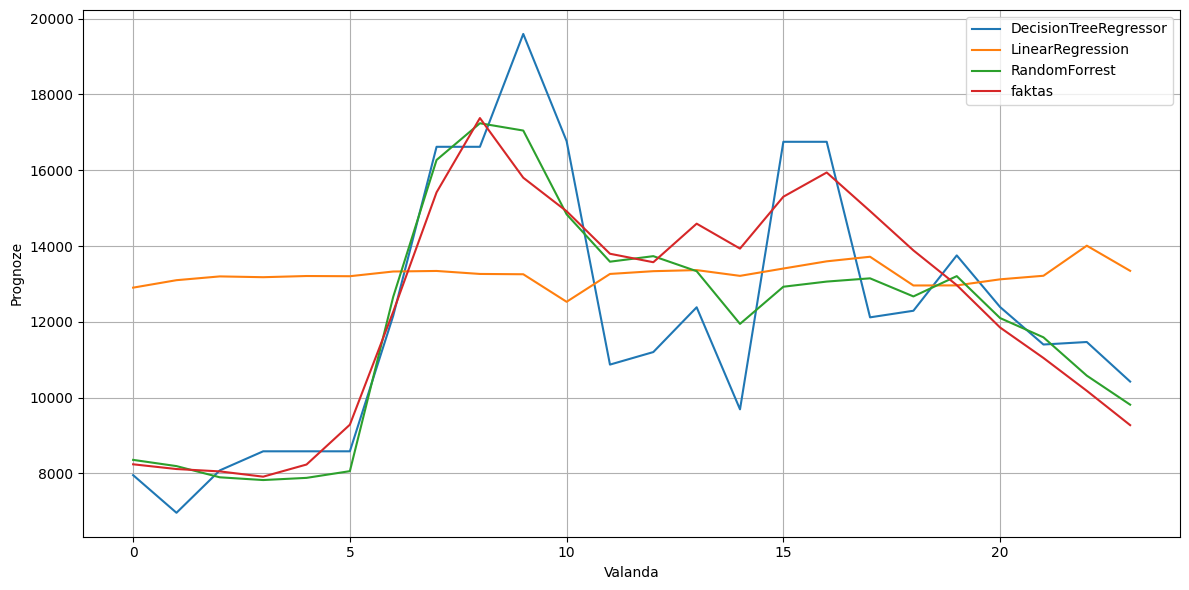

In [22]:
plt.figure(figsize=(12,6))
for column in ['DecisionTreeRegressor', 'LinearRegression', 'RandomForrest', 'faktas']:
    plt.plot(palyginimo_lentele['valanda'], palyginimo_lentele[column], label=column)

plt.xlabel('Valanda')
plt.ylabel('Prognoze')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("graph5.png")
plt.show()

In [23]:
from docx import Document                      # Importuojame Document klasę iš docx bibliotekos, reikalinga Word dokumentams kurti
from docx.shared import Inches                 # Importuojame Inches klasę, kad galėtume nustatyti paveikslėlių dydį dokumente
import os                                      # Importuojame os modulį, nors jis šiuo metu nėra naudojamas

def save_existing_graphs_to_docx(graph_files, output_filename):
    doc = Document()                           # Sukuriame naują Word dokumentą naudodami Document klasę

    for i, graph_file in enumerate(graph_files, start=1):
        doc.add_picture(graph_file, width=Inches(5))  # Pridedame paveikslėlį į dokumentą su nustatytu pločiu (5 coliai)

    doc.save(output_filename)                  # Išsaugome dokumentą su nurodytu failo pavadinimu

if __name__ == "__main__":
    graph_files = [f"graph{i}.png" for i in range(1, 6)]  # Sukuriame sąrašą su paveikslėlių failų pavadinimais (graph1.png, graph2.png, ...)
    output_filename = "grafikai.docx"                    # Nustatome išvesties dokumento failo pavadinimą
    
    save_existing_graphs_to_docx(graph_files, output_filename)  # Iškviečiame funkciją, kad išsaugotume paveikslėlius dokumente
    print(f"Grafikai išsaugoti dokumente '{output_filename}'.")  # Atspausdiname pranešimą, jog dokumentas sėkmingai išsaugotas


Grafikai išsaugoti dokumente 'grafikai.docx'.


In [24]:
pip install python-docx



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
# Modeliu tikslumas 
# Modelis: DecisionTreeRegressor mean_absolute_error: 665.7223843291862 mean_squared_error: 1041674.7807304055 r2: 0.8862213509676026
# Modelis: LinearRegression mean_absolute_error: 1805.6187895220594 mean_squared_error: 5819286.261970584 r2: 0.3643788431207463
# Modelis: RandomForestRegressor mean_absolute_error: 474.17321859086786 mean_squared_error: 541746.3660568128 r2: 0.9408268580670308

In [26]:
# Užduotis - paskaičiuoti geriausio modelio spėjimo įverčius (R2 score, etc), lyginannt spėjimą su NordPool
# faktu.

# Užduotis - parašyti skriptą, kuris pateiktų prognozę tiesiog skaičiuodamas vidutines vertes (pagal vidurkius)
# Palyginkite šio skripto prognozės tikslumą su dviem savo geriausiais modeliais 
# (pagal koreliacijos koef, R2 score, MAE, MSE, RMSE ...)

valandinis_suvartojimas = bendra_lentele
valandinis_suvartojimas['valanda'] = valandinis_suvartojimas['dateTime'].dt.hour
valandinis_suvartojimas = valandinis_suvartojimas.drop(columns='dateTime')
valandinis_suvartojimas.head()

valandinis_suvartojimas_sugrupuotas = valandinis_suvartojimas.groupby('valanda').mean()
valandinis_suvartojimas_sugrupuotas.head()

,viso
valanda,
0,8110.643755
1,7850.908759
2,7720.621073
3,7744.056924
4,7798.384287


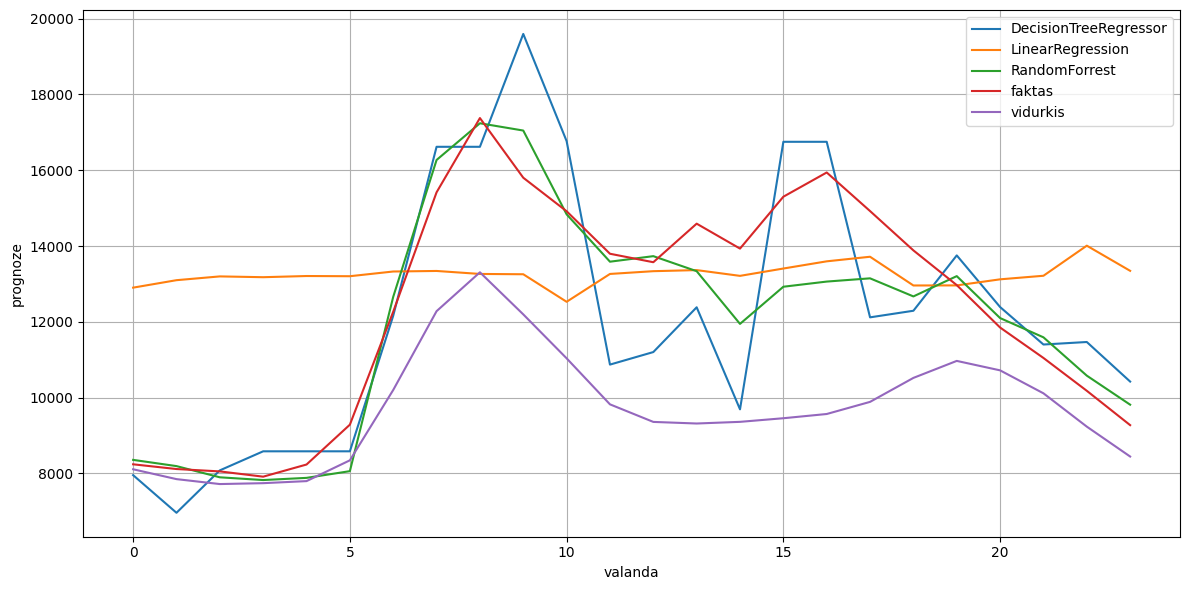

In [27]:
palyginimo_lentele.head()
vidurkis_vs_modeliai = pd.merge(left=palyginimo_lentele, right=valandinis_suvartojimas_sugrupuotas, left_on='valanda', right_on='valanda', how='inner')
vidurkis_vs_modeliai = vidurkis_vs_modeliai.rename(columns= {'viso': 'vidurkis'})
vidurkis_vs_modeliai.head()

plt.figure(figsize=(12,6))

for column in ['DecisionTreeRegressor', 'LinearRegression', 'RandomForrest', 'faktas', 'vidurkis']:
    plt.plot(vidurkis_vs_modeliai['valanda'], vidurkis_vs_modeliai[column], label=column)

plt.xlabel('valanda')
plt.ylabel('prognoze')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

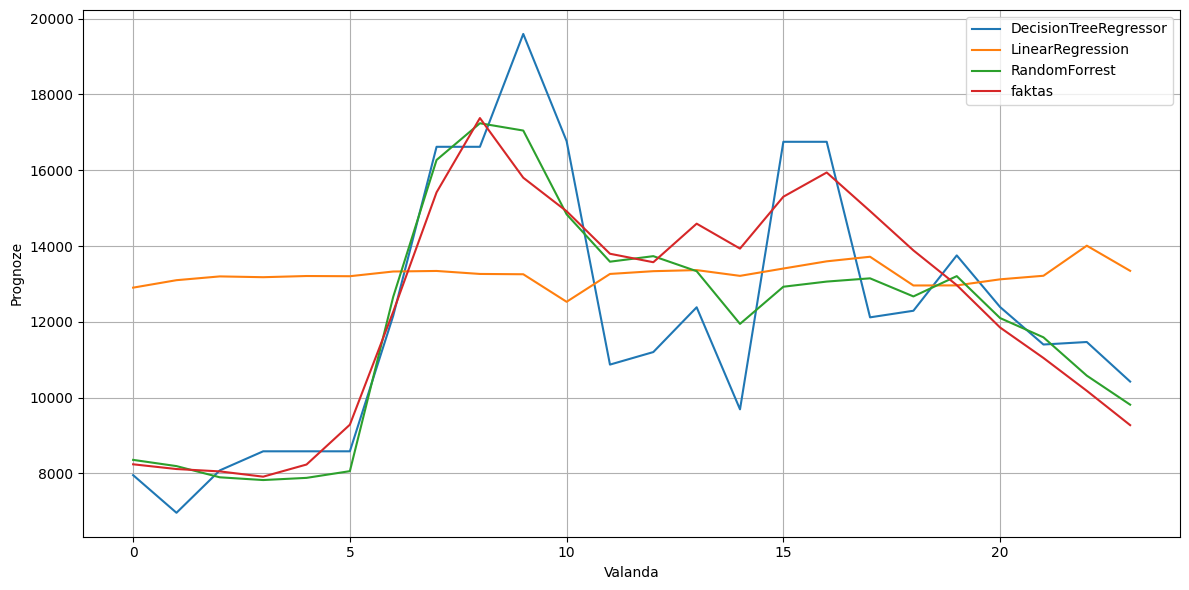

In [28]:
plt.figure(figsize=(12,6))
for column in ['DecisionTreeRegressor', 'LinearRegression', 'RandomForrest', 'faktas']:
    plt.plot(palyginimo_lentele['valanda'], palyginimo_lentele[column], label=column)

plt.xlabel('Valanda')
plt.ylabel('Prognoze')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("graph5.png")
plt.show()